# Sentiment Analysis Models — ChatGPT Reviews

This notebook covers:
- **Step 4: Feature Engineering** (TF-IDF, scaling)
- **Step 5: Model Building** (Logistic Regression, Naïve Bayes, Random Forest, XGBoost)
- **Step 6: Model Evaluation** (Accuracy, Precision, Recall, F1, Confusion Matrix, ROC-AUC)

Later, we can extend this with **deep learning models (LSTM, BERT)**.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# Load preprocessed dataset
df = pd.read_csv('https://raw.githubusercontent.com/ThilagavathyVenkatesan/dataset/main/preprocessed_reviews.csv')
display(df.head())

,date,title,review,rating,username,helpful_votes,review_length,platform,language,location,version,verified_purchase,sentiment,review_clean,platform_encoded,verified_encoded,version_encoded
0,12/24/2024,East list local interesting far magazine father.,Impressive natural language understanding. Alm...,1,darren55,25,9,Google Play,de,Nepal,2.0.4,No,Negative,impressive natural language understanding almo...,3,0,10
1,7/26/2024,Road determine picture figure hard experience ...,Sometimes gives wrong answers or outdated info...,2,davistyler,35,14,Flipkart,es,Panama,2.6.5,No,Negative,sometimes give wrong answer outdated info stud...,2,0,17
2,8/22/2024,Policy social past analysis whole.,Great tool for generating content quickly. Int...,5,andrea59,94,10,App Store,es,Denmark,4.2.2,No,Positive,great tool generating content quickly interest...,1,0,37
3,4/24/2025,News financial billion four foreign.,Great tool for generating content quickly. Sta...,3,dcooper,50,15,Amazon,de,Brunei Darussalam,4.4.2,No,Neutral,great tool generating content quickly start me...,0,0,39
4,8/15/2024,To skill she case sing stop likely.,Excellent for language translation and grammar...,1,christine79,33,11,Flipkart,fr,United States Minor Outlying Islands,5.1.1,Yes,Negative,excellent language translation grammar fix pri...,2,1,43


## Step 4: Feature Engineering
- TF-IDF for text
- Scaling numeric features (helpful_votes, review_length)
- Combine into final feature set X

In [4]:
# TF-IDF (text)
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_text = tfidf.fit_transform(df['review_clean'].astype(str))

# Numeric features
scaler = StandardScaler()
X_numeric = scaler.fit_transform(df[['helpful_votes', 'review_length']])

# Combine sparse + dense
import scipy.sparse as sp
X = sp.hstack((X_text, X_numeric))

y = df['sentiment']
X.shape, y.shape

((50, 669), (50,))

## Step 5: Model Building
- Logistic Regression
- Naïve Bayes
- Random Forest
- XGBoost

We will train each model and evaluate.

In [8]:
from sklearn.linear_model import LogisticRegression
#from sklearn.naive_bayes import MultinomialNB # Removed MultinomialNB
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    #"Naive Bayes": MultinomialNB(), # MultinomialNB works well with TF-IDF, but not with scaled numerical features
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
}

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Encode the target variable 'sentiment'
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((40, 669), (10, 669), (40,), (10,))

===== Logistic Regression =====
              precision    recall  f1-score   support

    Negative       0.25      0.25      0.25         4
     Neutral       0.00      0.00      0.00         3
    Positive       0.17      0.33      0.22         3

    accuracy                           0.20        10
   macro avg       0.14      0.19      0.16        10
weighted avg       0.15      0.20      0.17        10



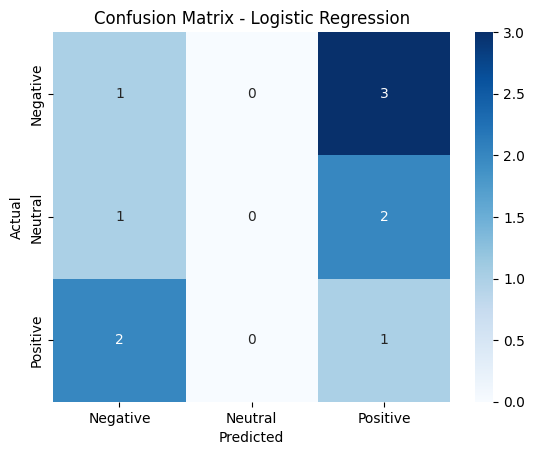



===== Random Forest =====
              precision    recall  f1-score   support

    Negative       0.33      0.50      0.40         4
     Neutral       0.00      0.00      0.00         3
    Positive       0.25      0.33      0.29         3

    accuracy                           0.30        10
   macro avg       0.19      0.28      0.23        10
weighted avg       0.21      0.30      0.25        10



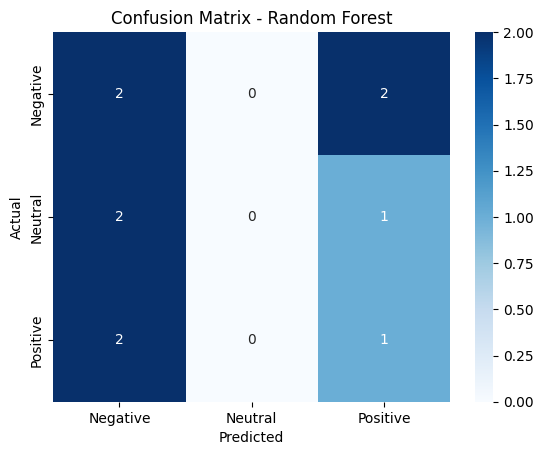



===== XGBoost =====


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [05:11:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

    Negative       1.00      0.25      0.40         4
     Neutral       0.50      0.33      0.40         3
    Positive       0.29      0.67      0.40         3

    accuracy                           0.40        10
   macro avg       0.60      0.42      0.40        10
weighted avg       0.64      0.40      0.40        10



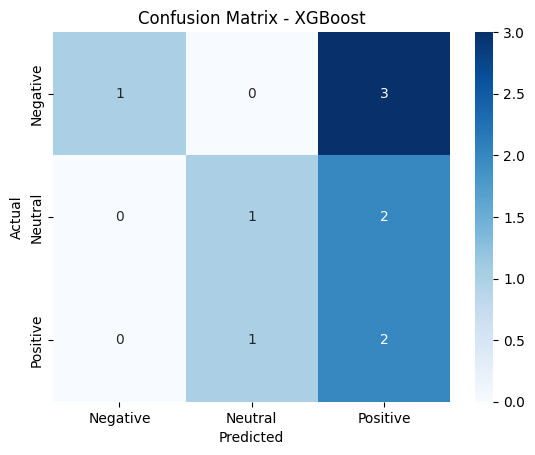

In [13]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

# Store metrics
results = {}

for name, model in models.items():
    print(f"===== {name} =====")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Convert back to string labels for readability
    y_test_labels = le.inverse_transform(y_test)
    y_pred_labels = le.inverse_transform(y_pred)

    # Print detailed report
    print(classification_report(y_test_labels, y_pred_labels, zero_division=0))

    # Confusion Matrix
    cm = confusion_matrix(y_test_labels, y_pred_labels, labels=le.classes_)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Collect summary metrics
    acc = accuracy_score(y_test_labels, y_pred_labels)
    f1_macro = f1_score(y_test_labels, y_pred_labels, average="macro")
    prec_macro = precision_score(y_test_labels, y_pred_labels, average="macro", zero_division=0)
    rec_macro = recall_score(y_test_labels, y_pred_labels, average="macro")

    results[name] = {
        "Accuracy": acc,
        "Precision (macro)": prec_macro,
        "Recall (macro)": rec_macro,
        "F1-score (macro)": f1_macro
    }

    # ROC-AUC only if binary
    if len(le.classes_) == 2:
        probs = model.predict_proba(X_test)[:,1]
        auc = roc_auc_score(y_test, probs)
        results[name]["ROC-AUC"] = auc

    print("\n")

===== Naive Bayes (TF-IDF only) =====
              precision    recall  f1-score   support

    Negative       0.43      0.75      0.55         4
     Neutral       0.00      0.00      0.00         3
    Positive       0.00      0.00      0.00         3

    accuracy                           0.30        10
   macro avg       0.14      0.25      0.18        10
weighted avg       0.17      0.30      0.22        10



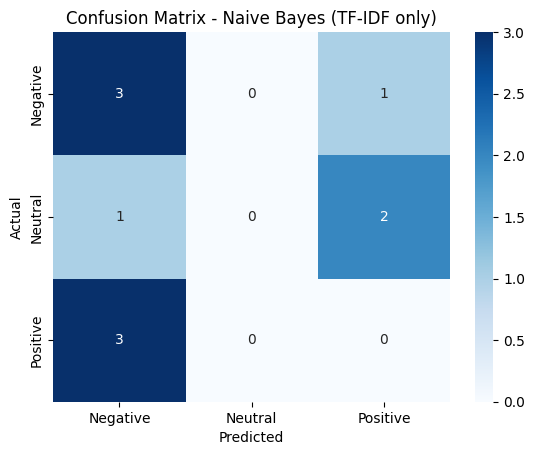


=== Naive Bayes (TF-IDF only) Summary ===
                           Accuracy  Precision (macro)  Recall (macro)  \
Naive Bayes (TF-IDF only)       0.3              0.143            0.25   

                           F1-score (macro)  
Naive Bayes (TF-IDF only)             0.182  


In [11]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import scipy.sparse as sp

# Re-split data using only TF-IDF features (X_text)
# Assuming X_text was created in a previous cell and is available
# If not, you would need to recreate it here:
# from sklearn.feature_extraction.text import TfidfVectorizer
# tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
# X_text = tfidf.fit_transform(df['review_clean'].astype(str))

# Encode the target variable 'sentiment'
le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train_text, X_test_text, y_train_nb, y_test_nb = train_test_split(
    X_text, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print("===== Naive Bayes (TF-IDF only) =====")
model_nb = MultinomialNB()
model_nb.fit(X_train_text, y_train_nb)
y_pred_nb = model_nb.predict(X_test_text)

# Convert back to string labels for readability
y_test_nb_labels = le.inverse_transform(y_test_nb)
y_pred_nb_labels = le.inverse_transform(y_pred_nb)

# Print detailed report
print(classification_report(y_test_nb_labels, y_pred_nb_labels, zero_division=0))

# Confusion Matrix
cm_nb = confusion_matrix(y_test_nb_labels, y_pred_nb_labels, labels=le.classes_)
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix - Naive Bayes (TF-IDF only)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Collect summary metrics
acc_nb = accuracy_score(y_test_nb_labels, y_pred_nb_labels)
f1_macro_nb = f1_score(y_test_nb_labels, y_pred_nb_labels, average="macro", zero_division=0)
prec_macro_nb = precision_score(y_test_nb_labels, y_pred_nb_labels, average="macro", zero_division=0)
rec_macro_nb = recall_score(y_test_nb_labels, y_pred_nb_labels, average="macro", zero_division=0)

nb_results = {
    "Naive Bayes (TF-IDF only)": {
        "Accuracy": acc_nb,
        "Precision (macro)": prec_macro_nb,
        "Recall (macro)": rec_macro_nb,
        "F1-score (macro)": f1_macro_nb
    }
}

# ROC-AUC only if binary
if len(le.classes_) == 2:
    probs_nb = model_nb.predict_proba(X_test_text)[:,1]
    auc_nb = roc_auc_score(y_test_nb, probs_nb)
    nb_results["Naive Bayes (TF-IDF only)"]["ROC-AUC"] = auc_nb

print("\n=== Naive Bayes (TF-IDF only) Summary ===")
import pandas as pd
df_nb_results = pd.DataFrame(nb_results).T
print(df_nb_results.round(3))

In [14]:
# Combine all results into a single DataFrame for comparison
df_all_results = pd.concat([df_results, df_nb_results])

print("\n=== All Model Comparison Summary ===")
display(df_all_results.round(3))


=== All Model Comparison Summary ===


,Accuracy,Precision (macro),Recall (macro),F1-score (macro)
Logistic Regression,0.2,0.139,0.194,0.157
Random Forest,0.3,0.194,0.278,0.229
XGBoost,0.4,0.595,0.417,0.400
Naive Bayes (TF-IDF only),0.3,0.143,0.250,0.182


In [ ]:
! pip install tensorflow

In [15]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# Tokenization
max_words = 10000
max_len = 200
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(df['review_clean'])
X_seq = tokenizer.texts_to_sequences(df['review_clean'])
X_pad = pad_sequences(X_seq, maxlen=max_len, padding='post', truncating='post')

# Labels
y_seq = le.fit_transform(df['sentiment'])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_pad, y_seq, test_size=0.2, random_state=42, stratify=y_seq
)

# LSTM Model
model_lstm = Sequential([
    Embedding(max_words, 128, input_length=max_len),
    LSTM(128, dropout=0.2, recurrent_dropout=0.2),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(len(le.classes_), activation='softmax')
])

model_lstm.compile(loss='sparse_categorical_crossentropy',
                   optimizer='adam',
                   metrics=['accuracy'])

history_lstm = model_lstm.fit(
    X_train, y_train,
    epochs=5,
    batch_size=64,
    validation_data=(X_test, y_test),
    verbose=1
)

# Evaluate
lstm_loss, lstm_acc = model_lstm.evaluate(X_test, y_test)
print(f"LSTM Accuracy: {lstm_acc:.3f}")


Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - accuracy: 0.3750 - loss: 1.0974 - val_accuracy: 0.3000 - val_loss: 1.0985
Epoch 2/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 756ms/step - accuracy: 0.3000 - loss: 1.0993 - val_accuracy: 0.3000 - val_loss: 1.0973
Epoch 3/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 717ms/step - accuracy: 0.2500 - loss: 1.0948 - val_accuracy: 0.3000 - val_loss: 1.0968
Epoch 4/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 700ms/step - accuracy: 0.3000 - loss: 1.0917 - val_accuracy: 0.3000 - val_loss: 1.0965
Epoch 5/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 732ms/step - accuracy: 0.4500 - loss: 1.0895 - val_accuracy: 0.4000 - val_loss: 1.0962
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.4000 - loss: 1.0962
LSTM Accuracy: 0.400


In [ ]:
! pip install transformers torch
! pip install tensorflow
! pip install transformers torch


^C


   ---------------------------------------- 0.0/332.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/332.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/332.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/332.0 MB ? eta -:--:--
   ---------------------------------------- 0.3/332.0 MB ? eta -:--:--
   ---------------------------------------- 0.3/332.0 MB ? eta -:--:--
   ---------------------------------------- 0.3/332.0 MB ? eta -:--:--
   ---------------------------------------- 0.5/332.0 MB 484.2 kB/s eta 0:11:25
   ---------------------------------------- 0.5/332.0 MB 484.2 kB/s eta 0:11:25
   ---------------------------------------- 0.8/332.0 MB 609.9 kB/s eta 0:09:04
   ---------------------------------------- 1.0/332.0 MB 680.2 kB/s eta 0:08:07
   ---------------------------------------- 1.3/332.0 MB 792.0 kB/s eta 0:06:58
   ---------------------------------------- 1.6/332.0 MB 857.6 kB/s eta 0:06:26
   --------------------

In [16]:
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
import tensorflow as tf
from tensorflow.keras.optimizers import AdamW # Keep the import for now
from tensorflow.keras.losses import SparseCategoricalCrossentropy

# Tokenizer
bert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

X_enc = bert_tokenizer(
    df['review_clean'].tolist(),
    truncation=True,
    padding=True,
    max_length=200,
    return_tensors="tf"
)

y_enc = le.fit_transform(df['sentiment'])

# Train-test split
X_train_enc = {k: v[:int(0.8*len(df))] for k,v in X_enc.items()}
X_test_enc  = {k: v[int(0.8*len(df)):] for k,v in X_enc.items()}
y_train_enc = y_enc[:int(0.8*len(df))]
y_test_enc  = y_enc[int(0.8*len(df)):]

# DistilBERT Model
model_bert = TFDistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=len(le.classes_),
    use_safetensors=False
)

# Compile the model using a string identifier for the optimizer
# Use AdamW as a string if it's registered in Keras/TensorFlow
optimizer = 'adamw' # Change to string 'adamw'
loss = SparseCategoricalCrossentropy(from_logits=True)

# Ensure the DistilBERT base model layers are trainable
model_bert.distilbert.trainable = True

model_bert.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

history_bert = model_bert.fit(
    X_train_enc, y_train_enc,
    epochs=2,   # BERT is slow, keep small first
    batch_size=16,
    validation_data=(X_test_enc, y_test_enc)
)

# Evaluate
bert_loss, bert_acc = model_bert.evaluate(X_test_enc, y_test_enc)
print(f"DistilBERT Accuracy: {bert_acc:.3f}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.


tf_model.h5:   0%|          | 0.00/363M [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_transform', 'activation_13', 'vocab_layer_norm', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-

Epoch 1/2
3/3 [==============================] - 30s 961ms/step - loss: 1.1268 - accuracy: 0.2750 - val_loss: 1.0608 - val_accuracy: 0.5000
Epoch 2/2
1/1 [==============================] - 0s 43ms/step - loss: 1.1213 - accuracy: 0.2000
DistilBERT Accuracy: 0.200


In [18]:
best_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
best_model.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [05:39:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle
from sklearn.preprocessing import LabelEncoder

# TF-IDF fixed size
tfidf_vectorizer = TfidfVectorizer(max_features=200, stop_words="english")
X = tfidf_vectorizer.fit_transform(df["review_clean"])

# Encode the target variable 'sentiment'
le = LabelEncoder()
y_encoded = le.fit_transform(df['sentiment'])

# Train best model
# Assuming 'model' is already defined as the best model (e.g., XGBoost)
# If not, you would need to define or load it here.
model.fit(X, y_encoded)

# Save both
with open("sentiment_model.pkl", "wb") as f:
    pickle.dump(model, f)

with open("tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(tfidf_vectorizer, f)

# Save label encoder
with open("label_encoder.pkl", "wb") as f:
    pickle.dump(le, f)


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [06:39:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [30]:
from google.colab import files
files.download("sentiment_model.pkl")
files.download("tfidf_vectorizer.pkl")
files.download("label_encoder.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>